In [1]:
import time
#import cupy as cu
import numpy as np
import pandas as pa

import readDICOM as dcm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {'grid.linestyle': '--'})
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import os
workspace = os.getcwd()
def calTime(end, start):
    elapsed_time = end - start
    q, mod = divmod(elapsed_time, 60)
    if q < 60:
        print('Calculation time: %d minutes %d seconds.' % (q, mod))
    else:
        q2, mod2 = divmod(q, 60)
        print('Calculation time: %d h %d minutes.' % (q2, mod2))

# Monte Carlo class

In [237]:
class MonteCalroPh(object):
    def __init__(self,sample_model,fluence = False):
        self.model = sample_model
        self.vectorTh = 0.99999
        self.fluence = fluence
        
    def generateInisalData(self,nPh,f_bit):
        p = np.zeros((3,nPh),dtype = f_bit)
        v = np.zeros((3,nPh),dtype = f_bit)
        v[2] = 1
        w = self.initialWeight(np.full(nPh,1).astype(f_bit))
        return p,v,w
    
    def initialWeight(self,w):
        Rsp = 0
        n1 = self.model.ref_index[0]
        n2 = self.model.ref_index[1]
        if n1 != n2:
            Rsp = ((n1-n2)/(n1+n2))**2
        return w-Rsp
    
    ####### Mainの関数 #######
    def startMonteCalro(self,nPh):
        print("")
        print("###### Start ######")
        print("")
        
        f_bit = 'float32'
        start_ = time.time()

        #初期値の設定
        p,v,w = self.generateInisalData(nPh,f_bit)

        #結果保存用の配列を定義
        v_result = np.empty((3,1)).astype(f_bit)
        p_result = np.empty((3,1)).astype(f_bit)
        w_result = np.empty(1).astype(f_bit)
        
        count = 0
        counter = 2
        trace = []
            
        # Let's MonteCalro!
        while list(w) != []:
            
            p,v,w,result = self.stepMovement(p,v,w,f_bit)
            #trace.append(p)
            if result[0][0].tolist() != []:
                p_result = np.concatenate([p_result, result[0]],axis = 1)
                v_result = np.concatenate([v_result, result[1]],axis = 1)
                w_result = np.concatenate([w_result, result[2]])
            count+=1
            if count%counter==0:
                counter*=2
                print("Progress: %s [％]"%round((1-w.size/nPh)*100,3))
                calTime(time.time(), start_)
                print()

        #結果の表示
        print("")
        print("###### Result ######")
        print("Maximum step number: %s"%count)
        print("Photon weight reduction late: %s ％"%round((1-np.sum(w_result)/nPh)*100,3))
        calTime(time.time(), start_)
        v_result = v_result[:,1:]
        p_result = p_result[:,1:]
        w_result = w_result[1:]
        return p_result,v_result,w_result,trace
    
    #光の動きを制御する
    def stepMovement(self,p,v,w,f="float32"):
        ## 光子の位置並びにベクトルを更新します。
        #１stepで光子が進む予定の距離を定義
        s = self.stepLength(p[0].size,f)
        #境界を超える光子のindexを取得

        pb_index,l,dl,ma,mt,g,n_mt = self.model.boundaryJudgment(p,v,s)
        #光子位置を更新
        p = self.positionUpdate(p,v,l)

        if list(pb_index) != []:
            #境界上光子のベクトルの更新
            v[:,pb_index] = self.updateOnBoundary(v[:,pb_index],p[:,pb_index],f)
            inde = np.where(n_mt[pb_index]!= 0)[0]
            dl = dl[inde]*mt[pb_index[inde]]/n_mt[pb_index[inde]]
            p[:,pb_index[inde]] = self.positionUpdate(p[:,pb_index[inde]],v[:,pb_index[inde]],dl)
            #境界を超えない光子の位置,ベクトルを更新
            pn_index = np.delete(np.arange(p[2].size),pb_index)
            v[:,pn_index] = self.vectorUpdate(v[:,pn_index],g[pn_index],f)
            w[pn_index] = self.wUpdate(w[pn_index],ma[pn_index],mt[pn_index],1,p[:,pn_index])
            
        else:#全ての光子が境界に乗っていない時
            v= self.vectorUpdate(v,g,f)
            w = self.wUpdate(w,ma,mt,1,p)
            
        p,v,w,result=self.model.borderOut(p,v,w)
        p,v,w = self.photonVanishing(w,p,v)
        return p,v,w,result

    def photonVanishing(self,w,p,v):
        #photn waight が0.0001以下
        del_index = np.where(w<=0.0001)[0]
        if list(del_index) != []:
            w[del_index] = self.russianRoulette(w[del_index])
            del_index = np.where(w==0)[0]
            v = np.delete(v, del_index, axis = 1)
            p = np.delete(p, del_index, axis = 1)
            w = np.delete(w, del_index)
        return p,v,w
    
    def russianRoulette(self,w,f="float32"):
        ## 確率的に光子を生き返らせます。
        m = 10
        ra = np.random.rand(w.size).astype(f)
        index = np.where(ra>(1/m))[0].tolist()
        w[index] = 0
        index = np.where(ra<=(1/m))[0].tolist()
        w[index] = w[index]*m
        return w
    
    def updateOnBoundary(self,v,p,f="float32"):
        ## ここでは、透過判別や反射、屈折の計算を行います。
        #境界を超える前後の屈折率を取得  
        ni,nt = self.model.getNiNt(p,v)
        #境界前後で屈折率が変化する場合のindex
        pb_index = np.where(ni!=nt)[0]
        
        if list(pb_index) != []:
            #透過判別
            #入射角の計算
            ai = self.model.getIncidentAngle(v[:,pb_index])
            #全反射するときのインデックスを取得
            sub_index = np.where((ai>np.arcsin(nt[pb_index]/ni[pb_index])))[0]
            #屈折角の計算
            ##(ai,at)=(0,0)の時は透過させ方向ベクトルは変化させない
            at = np.arcsin(ni[pb_index]*np.sin(ai)/nt[pb_index])
            Ra = np.random.rand(ai.size)\
            -((np.sin(ai-at)/np.sin(ai+at))**2+(np.tan(ai-at)/np.tan(ai+at))**2)/2
            #全反射はRaを強制的に0以下にし反射させる
            Ra[sub_index] = -1
            #透過と反射のindexを取得
            vl_index = pb_index[np.where(Ra<=0)[0]]#反射
            sub_index = np.where(Ra>0)[0]
            vt_index = pb_index[sub_index]#透過
            at = at[sub_index]
            #ベクトルを更新
            v = self.model.boundaryVectorUpdate(v,at,ni/nt,vl_index,vt_index)
        return v

    def vectorUpdate(self,v,G,f="float32"):
        index = np.where(G==0.0)[0]
        cosTh = np.empty_like(G)
        if list(index) != []:
            rand_num = np.random.rand(G.size).astype(f)
            cosTh[index] = 2*rand_num[index]-1
            index = np.where(G!=0)[0]
            if list(index) != []:
                cosTh[index] = ((1+G[index]**2\
                                 -((1-G[index]**2)/(1-G[index]+2*G[index]*rand_num[index]))**2)/(2*G[index]))
        else:
            cosTh = (1+G**2-((1-G**2)/(1-G+2*G*np.random.rand(G.size).astype(f)))**2)/(2*G)
        sinTh = np.sin(np.arccos(cosTh))
        
        #cos(fai)とsin(fai)と求める
        Fi = 2*np.pi*np.random.rand(G.size).astype(f)
        cosFi = np.cos(Fi)
        sinFi = np.sin(Fi)
        
        #Zが１かそれ以外で分離
        th = self.vectorTh
        v1_index = np.where(np.abs(v[2])<=th)[0]
        v2_index = np.where(np.abs(v[2])>th)[0]
        
        if list(v1_index) != []:
            #Z方向ベクトルが0.99999以下
            v1 = v[:,v1_index]
            cosTh1 = cosTh[v1_index]; sinTh1 = sinTh[v1_index]
            cosFi1 = cosFi[v1_index]; sinFi1 = sinFi[v1_index]
            B = np.sqrt(1-v1[2]**2)
            A = np.array([
                sinTh1*(v1[0]*v1[2]*cosFi1-v1[1]*sinFi1)/B,
                sinTh1*(v1[1]*v1[2]*cosFi1+v1[0]*sinFi1)/B,
                -sinTh1*cosFi1*B,
            ])
            v[:,v1_index] = A+v1*cosTh1
            
        if list(v2_index) != []:
            #Z方向ベクトルが0.99999以上
            v1 = v[:,v2_index]
            cosTh1 = cosTh[v2_index]; sinTh1 = sinTh[v2_index]
            cosFi1 = cosFi[v2_index]; sinFi1 = sinFi[v2_index]
            v[:,v2_index] = np.array([
                sinTh1*cosFi1,
                sinTh1*sinFi1,
                np.sign(v1[2])*cosTh1,
            ],dtype=f)
        v = v/np.linalg.norm(v,axis=0)
        return v

    def positionUpdate(self,p,v,L):
        return p+v*L

    #光子の１ステップにおけるエネルギーの損失を計算
    def wUpdate(self,w,ma,mt,rato,p):
        dw = w*rato*ma/mt
        if self.fluence != False:
            self.fluence.saveFluesnce(p,dw)
        return w-dw
            
    def russianRoulette(self,w,f="float32"):
        ## 確率的に光子を生き返らせます。
        m = 10
        ra = np.random.rand(w.size).astype(f)
        index = np.where(ra>(1/m))[0].tolist()
        w[index] = 0
        index = np.where(ra<=(1/m))[0].tolist()
        w[index] = w[index]*m
        return w

    #光子の移動距離, uniformly distributed over the interval (0,1)
    def stepLength(self,size,f="float32"):
        return -np.log(np.random.rand(size)).astype(f)
 
    
    
class IntarnalFluence(object):
    def __init__(self,nr,nz,dr,dz):
        self.r = np.array([(i)*dr for i in range(nr+1)])
        self.z = np.array([(i)*dz for i in range(nz+1)])
        self.Arz = np.zeros((nr,nz),dtype = 'float16')
        self.nr = nr
        self.nz = nz
        self.dr = dr
        self.dz = dz
        
    def saveFluesnce(self,p,w):
        rr = np.sqrt(p[0]**2+p[1]**2)
        zz = p[2]
        index_in = np.where((zz<=self.z[-1])&(rr<=self.r[-1]))[0]
        index_r = self.getIndex(self.r,rr[index_in],self.dr)
        index_z = self.getIndex(self.z,zz[index_in],self.dz)
        self.sumationW(w[index_in],index_r,index_z)

    def sumationW(self,w,indexr,indexz):
        unique_id = (indexr*self.nz*10000+indexz)
        AA = np.array([indexr,indexz]).T
        for i in np.unique(unique_id):
            index = np.where(unique_id==i)[0]
            sum_w = w[index].sum()
            inxez_Arz = AA[index][0]
            self.Arz[inxez_Arz[0],inxez_Arz[1]] = self.Arz[inxez_Arz[0],inxez_Arz[1]] + sum_w
    
    def getIndex(self,standard,posi,d):
        ff = float
        """sub = np.intersect1d(posi.astype(ff), (standard+d/2).astype(ff))
        index = np.where(np.tile(posi,(sub.size,1)).astype(ff).T-sub == 0)[0]
        posi[index] = posi[index]-d/4
        sub = np.intersect1d(posi.astype(ff), standard.astype(ff))
        index = np.where(np.tile(posi.astype(ff),(sub.size,1)).astype(ff).T-sub == 0)[0]
        posi[index] = posi[index]+d/4"""

        c = abs(np.tile(posi,(standard.size,1)).astype(ff).T-standard)
        d = np.array(np.where(c.T==np.sort(c,axis=1)[:,0]))
        d = d[:,np.argsort(d[1])]
        e = np.array(np.where(c.T==np.sort(c,axis=1)[:,1]))
        e = e[:,np.argsort(e[1])]
        return np.array([d[0],e[0]]).min(0)

    def getArrayZ(self):
        return np.array([(i+0.5)*self.dz for i in range(self.nz)])
    
    def getArrayR(self):
        return np.array([(i+0.5)*self.dr for i in range(self.nr)])
    
class SolidPlateModel(object):
    def __init__(self,thickness,ma_list,ms_list,g_list,n_list,n_air,f = 'float32'):
        thickness = [0]+thickness
        b = 0; b_list = []
        for i in  thickness:
            b += i
            b_list.append(b)
        self.f = f
        self.borderposit = np.array(b_list).astype(f)
        self.ref_index =np.array([n_air]+n_list+[n_air]).astype(f)
        self.ms = np.array(ms_list).astype(f)
        self.ma = np.array(ma_list).astype(f)
        self.g = np.array(g_list).astype(f)
    
    # 境界への入射角を定義
    def getIncidentAngle(self,v):
        return np.arccos(abs(v[2]))

    def getDistanceBoundary(self,p,v):
        index_positive = np.where(v[2]>0)[0]
        index_negative = np.where(v[2]<0)[0]
        index_zero = np.where(v[2]==0)[0]

        index_border = self.getBorderIndex(p,v)

        border = self.borderposit
        tilearray = np.tile(border,(p[2].size,1))

        shallow = (tilearray*self.create01Array(index_border,m=border.size).T).max(1)
        deep = (tilearray*self.create01Array(index_border+1,m=border.size).T).max(1)
        
        S = np.empty_like(p[2])
        S[index_negative] = (shallow[index_negative] - p[2,index_negative])/v[2,index_negative]
        S[index_positive] = (deep[index_positive] - p[2,index_positive])/v[2,index_positive]
        S[index_zero]=1000
        return abs(S)
                   
    #屈折率ni,ntの取得
    def getNiNt(self,p,v):
        ind_negative = np.where(v[2]<0)[0]
        ind_positive = np.where(v[2]>0)[0]
        pz = p[2]
        n = self.ref_index
        border = self.borderposit
        index = np.argmin(np.abs(np.tile(border,(pz.size,1))-np.tile(pz,(border.size,1)).T),axis = 1)
        n_array = np.tile(n,(index.size,1)).T
        shallow = (n_array*self.create01Array(index,m=border.size+1)).max(0)
        deep = (n_array*self.create01Array(index+1,m=border.size+1)).max(0)

        ni = np.empty_like(pz)
        nt = np.empty_like(pz)
        ni[ind_positive] = shallow[ind_positive]
        ni[ind_negative] = deep[ind_negative]
        nt[ind_positive] = deep[ind_positive]
        nt[ind_negative] = shallow[ind_negative]
        return ni,nt
    
    #任意の位置(indexの行)が１でそれ以外は0の行列を作る
    def create01Array(self,index,m=3):
        n = index.size
        array_0_1 = np.zeros(m*n,dtype = bool)
        array_0_1[index+m*np.arange(n)] = 1
        return array_0_1.reshape(n,m).T 
    
    def borderOut(self,p,v,w):
        margin = 1e-8
        border = self.borderposit
        del_index = np.where(((p[2]<=border[0]+margin)&(v[2]<0))|((p[2]>=border[-1]-margin)&(v[2]>0)))[0]
        result = list([p[:,del_index],v[:,del_index],w[del_index]])
        index = np.where((p[2]<=border[0])&(v[2]>0))[0]
        p[2,index] = border[0]
        index = np.where((p[2]>=border[-1])&(v[2]<0))[0]
        p[2,index] = border[-1]
        v = np.delete(v, del_index, axis = 1)
        p = np.delete(p, del_index, axis = 1)
        w = np.delete(w, del_index)
        return p,v,w,result
    
    # 境界上のベクトル更新
    def boundaryVectorUpdate(self,v,at,snell_rato,vl_index,vt_index):
        #反射するとき
        if list(vl_index) !=[]:
            v[2,vl_index] = -v[2,vl_index]
            
        #透過するときのベクトルを更新
        if list(vt_index)!=[]:
            v[0,vt_index] = snell_rato[vt_index]*v[0,vt_index]
            v[1,vt_index] = snell_rato[vt_index]*v[1,vt_index]
            v[2,vt_index] = np.sign(v[2,vt_index])*np.cos(at)
        return v
    
    def getNextOpticalProperties(self,p,v):
        index = self.getBorderIndex(p,v)
        n_index = np.sign(v[2])+index
        index_index = np.where((n_index > 0) & (n_index < self.ma.size))[0]
        data = np.zeros((3,p[2].size))
        A = self.create01Array(n_index[index_index].astype('int16'),m=self.ma.size).T

        data[0,index_index] = (np.tile(self.ma,(index_index.size,1))*A).max(1)
        data[1,index_index] = (np.tile(self.ms,(index_index.size,1))*A).max(1)
        data[2,index_index] = (np.tile(self.g,(index_index.size,1))*A).max(1)
        return data
    
    def getOpticalProperties(self,p,v):
        index = self.getBorderIndex(p,v)
        data = np.empty((3,p[2].size))
        p_size = p[2].size
        A = self.create01Array(index,m=self.ma.size).T
        data[0] = (np.tile(self.ma,(p_size,1))*A).max(1)
        data[1] = (np.tile(self.ms,(p_size,1))*A).max(1)
        data[2] = (np.tile(self.g,(p_size,1))*A).max(1)
        return data
    
    # 境界判別と光子移動距離の更新
    def boundaryJudgment(self,p,v,s):
        ma,ms,g = self.getOpticalProperties(p,v)
        n_ma,n_ms,_ = self.getNextOpticalProperties(p,v)
        mt = ma+ms
        s = s/mt
        n_mt = n_ma+n_ms
        db = self.getDistanceBoundary(p,v)
        pb_index = np.where((s-db)>=0)[0]
        dl = s[pb_index]-db[pb_index]
        s[pb_index] = db[pb_index]
        return pb_index,s,dl,ma,mt,g,n_mt

    def getBorderIndex(self,p,v):
        border = self.borderposit
        d = np.sign(np.tile(border,(p[2].size,1))-np.tile(p[2],(border.size,1)).T).astype('int16')
        ind = np.array(np.where(d==0))
        if list(ind[0])!= []:
            d[ind[0],ind[1]] = -np.sign(v[2,ind[0]])
        return np.where(d[:,:-1] != d[:,1:])[1]

In [130]:
aa = np.array([])
if list(aa)!=[]:
    print("Infinity")

# Test code

In [230]:
thickness=[0.1,0.1,0.2]
ms = [100,10,10]
ma = [1,1,2]
g = [0.9,0.0,0.7]
n = [1.37,1.37,1.37]
n_air = 1.
model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
nPh = 10
p_result,v_result,w_result,trace = monte.startMonteCalro(nPh)



###### Start ######

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 20.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 50.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 60.0 [％]
Calculation time: 0 minutes 0 seconds.


###### Result ######
Maximum step number: 119
Photon weight reduction late: 61.524 ％
Calculation time: 0 minutes 0 seconds.


In [148]:
aa = [
    [False,False,True],
    [False,True, False],
    [False,True,False],
    [True,True,False],
    [False,False,True],
]
np.where(aa)

(array([0, 1, 2, 3, 3, 4]), array([2, 1, 1, 0, 1, 2]))

# Computation Results of single-solidmodel and mcml

## Total diffuse reflectance and total transmittance

### slab of turbid medium

In [171]:
thickness=[0.02]
ms = [90]
ma = [10]
g = [0.75]
n = [1.]
n_air = 1.
model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
nPh = 50000

margin = 1e-8
Tt = []; Rd = []
for i in range(10):
    p_result,v_result,w_result,_ = monte.startMonteCalro(nPh)
    Tt_index = np.where(p_result[2]>=thickness[0]-margin)[0]
    Rd_index = np.where(p_result[2]<=margin)[0]
    Tt.append(w_result[Tt_index].sum()/nPh)
    Rd.append(w_result[Rd_index].sum()/nPh)
    print('######')
    print('Mean Tt %0.6f'%Tt[-1])
    print('Mean Rd %0.6f'%Rd[-1])
    print()


###### Start ######

Progress: 36.156 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 70.064 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 92.12 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 99.256 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 99.992 [％]
Calculation time: 0 minutes 0 seconds.


###### Result ######
Maximum step number: 43
Photon weight reduction late: 24.069 ％
Calculation time: 0 minutes 0 seconds.
######
Mean Tt 0.662345
Mean Rd 0.096966


###### Start ######

Progress: 35.592 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 70.02 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 91.962 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 99.176 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 99.996 [％]
Calculation time: 0 minutes 0 seconds.


###### Result ######
Maximum step number: 34
Photon weight reduction late: 24.211 ％
Calculation time: 0 minutes 0 seconds.
######
Mean Tt 0.659329
Mean Rd 0.098560


###### Start ##

In [172]:
print('Mean Tt %0.6f, sd_error %0.6f'%(np.mean(Tt),np.std(Tt)/np.sqrt(len(Tt))))
print('Mean Rd %0.6f, sd_error %0.6f'%(np.mean(Rd),np.std(Rd)/np.sqrt(len(Rd))))

Mean Tt 0.660640, sd_error 0.000488
Mean Rd 0.097792, sd_error 0.000236


### Semi-infinite turbid medium that has mismatched refractive index with the ambient medium

In [92]:
print(p_result)

[[ inf  inf  inf ...  inf -inf -inf]
 [-inf -inf -inf ...  inf -inf  inf]
 [-inf -inf -inf ... -inf  inf -inf]]


In [173]:
thickness=[200]
ms = [90]
ma = [10]
g = [0]
n = [1.5]
n_air = 1.
model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
nPh = 50000

margin = 1e-8
Tt = []; Rd = []
for i in range(10):
    p_result,v_result,w_result,_ = monte.startMonteCalro(nPh)
    Tt_index = np.where(p_result[2]>=thickness[0]-margin)[0]
    Rd_index = np.where(p_result[2]<=margin)[0]
    Tt.append(w_result[Tt_index].sum()/nPh)
    Rd.append(w_result[Rd_index].sum()/nPh)
    print('######')
    print('Mean Tt %0.6f'%Tt[-1])
    print('Mean Rd %0.6f'%Rd[-1])
    print()


###### Start ######

Progress: 5.448 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 12.364 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 22.77 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 35.552 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 49.212 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 61.762 [％]
Calculation time: 0 minutes 1 seconds.

Progress: 99.728 [％]
Calculation time: 0 minutes 1 seconds.


###### Result ######
Maximum step number: 181
Photon weight reduction late: 78.096 ％
Calculation time: 0 minutes 1 seconds.
######
Mean Tt 0.000000
Mean Rd 0.219039


###### Start ######

Progress: 5.31 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 12.442 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 22.752 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 35.68 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 49.29 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 61.852 [％]
Calculation time: 0 minutes 1 seconds.

Pr

In [174]:
print('Mean Tt %0.6f, sd_error %0.6f'%(np.mean(Tt),np.std(Tt)/np.sqrt(len(Tt))))
print('Mean Rd %0.6f, sd_error %0.6f'%(np.mean(Rd),np.std(Rd)/np.sqrt(len(Rd))))

Mean Tt 0.000000, sd_error 0.000000
Mean Rd 0.220074, sd_error 0.000202


## Angularly resolved diffuse reflectance and transmittance

In [27]:
def AngularyResolved(v,w,nn):
    da = np.pi/(2*nn)
    alpha = np.array([(i+0.5)*da for i in range(nn+1)])
    alpha2 = np.array([(i)*da for i in range(nn+1)])
    do = 4*np.pi*np.sin(alpha)*np.sin(da/2)
    at = np.arccos(np.sign(v[2])*(v[2]))
    Rda = []
    for i in range(nn):
        index = np.where((alpha2[i]<at)&(alpha2[i+1]>=at))[0]
        Rda.append(w[index].sum())
    Rda = np.array(Rda)/(do[:-1]*nPh)
    return alpha[:-1],Rda


In [175]:
thickness=[0.02]
ms = [90]
ma = [10]
g = [0.75]
n = [1.]
n_air = 1.
model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
nPh = 500000

p_result,v_result,w_result,trace = monte.startMonteCalro(nPh)
Tt_index = np.where(v_result[2]>0)[0]
Rd_index = np.where(v_result[2]<0)[0]
print('######')
print('Mean Tt %0.6f'%(w_result[Tt_index].sum()/nPh))
print('Mean Rd %0.6f'%(w_result[Rd_index].sum()/nPh))
print()


###### Start ######

Progress: 35.943 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 70.162 [％]
Calculation time: 0 minutes 1 seconds.

Progress: 91.936 [％]
Calculation time: 0 minutes 1 seconds.

Progress: 99.223 [％]
Calculation time: 0 minutes 1 seconds.

Progress: 99.991 [％]
Calculation time: 0 minutes 2 seconds.


###### Result ######
Maximum step number: 43
Photon weight reduction late: 24.145 ％
Calculation time: 0 minutes 2 seconds.
######
Mean Tt 0.661156
Mean Rd 0.097398



Trancemittance


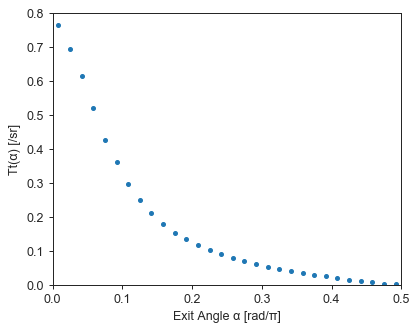

In [176]:
print('Trancemittance')
nn = 30

alpha,Tta = AngularyResolved(v_result[:,Tt_index],w_result[Tt_index],nn)

plt.figure(figsize=(5,4),dpi=90)
plt.plot(alpha/np.pi,Tta,'.')
plt.xlabel('Exit Angle α [rad/π]')
plt.ylabel('Tt(α) [/sr]')
plt.xlim(0,0.5)
plt.ylim(0,0.8)
plt.show()

Refrected


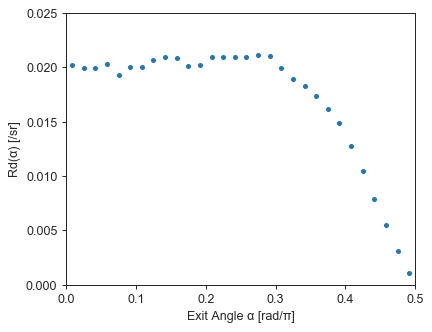

In [177]:
print('Refrected')
nn = 30
alpha,Rda = AngularyResolved(v_result[:,Rd_index],w_result[Rd_index],nn)

plt.figure(figsize=(5,4),dpi=90)
plt.plot(alpha/np.pi,Rda,'.')
plt.xlabel('Exit Angle α [rad/π]')
plt.ylabel('Rd(α) [/sr]')
plt.xlim(0,0.5)
plt.ylim(0,0.025)
plt.show()

In [24]:
df_ = pa.DataFrame(np.array([alpha/np.pi,Rda,Tta]).T,columns = ['Angle','Rd','Tt'])
df_.to_csv('result/angle.csv',index=None)

## Radially resolved diffuse reflectance

In [20]:
def radialDistance(p,w,nn,dr):
    alpha = np.array([(i)*dr for i in range(nn+1)])
    da = np.array([2*np.pi*(i+0.5)*dr**2 for i in range(nn)])
    r = np.sqrt(p[0]**2+p[1]**2)
    Rdr = []
    for i in range(nn):
        index = np.where((alpha[i]<r)&(alpha[i+1]>=r))[0]
        Rdr.append(w[index].sum())
    Rdr = np.array(Rdr)/(da*nPh)
    return alpha[:-1],Rdr


In [187]:
thickness=[200]
ms = [100]
ma = [0.1]
g = [0.9]
n = [1.]
n_air = 1.
model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
nPh = 500000

p_resultA,v_resultA,w_resultA,trace = monte.startMonteCalro(nPh)
Tt_indexA = np.where(v_resultA[2]>0)[0]
Rd_indexA = np.where(v_resultA[2]<0)[0]
print('######')
print('Mean Tt %0.6f'%(w_resultA[Tt_indexA].sum()/nPh))
print('Mean Rd %0.6f'%(w_resultA[Rd_indexA].sum()/nPh))
print()


###### Start ######

Progress: 0.609 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 1.966 [％]
Calculation time: 0 minutes 1 seconds.

Progress: 5.032 [％]
Calculation time: 0 minutes 3 seconds.

Progress: 11.982 [％]
Calculation time: 0 minutes 6 seconds.

Progress: 24.772 [％]
Calculation time: 0 minutes 11 seconds.

Progress: 40.934 [％]
Calculation time: 0 minutes 19 seconds.

Progress: 55.979 [％]
Calculation time: 0 minutes 31 seconds.

Progress: 68.077 [％]
Calculation time: 0 minutes 49 seconds.

Progress: 77.113 [％]
Calculation time: 1 minutes 14 seconds.

Progress: 83.667 [％]
Calculation time: 1 minutes 49 seconds.

Progress: 88.367 [％]
Calculation time: 2 minutes 42 seconds.

Progress: 91.784 [％]
Calculation time: 4 minutes 4 seconds.

Progress: 94.198 [％]
Calculation time: 6 minutes 10 seconds.

Progress: 100.0 [％]
Calculation time: 6 minutes 43 seconds.


###### Result ######
Maximum step number: 18430
Photon weight reduction late: 25.438 ％
Calculation time: 6 minutes 44 

In [188]:
thickness=[200]
ms = [10]
ma = [0.1]
g = [0.]
n = [1.]
n_air = 1.
model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
nPh = 500000

p_resultB,v_resultB,w_resultB,trace = monte.startMonteCalro(nPh)
Tt_indexB = np.where(v_resultB[2]>0)[0]
Rd_indexB = np.where(v_resultB[2]<0)[0]
print('######')
print('Mean Tt %0.6f'%(w_resultB[Tt_indexB].sum()/nPh))
print('Mean Rd %0.6f'%(w_resultB[Rd_indexB].sum()/nPh))
print()


###### Start ######

Progress: 15.365 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 31.994 [％]
Calculation time: 0 minutes 1 seconds.

Progress: 47.669 [％]
Calculation time: 0 minutes 2 seconds.

Progress: 61.118 [％]
Calculation time: 0 minutes 4 seconds.

Progress: 71.667 [％]
Calculation time: 0 minutes 6 seconds.

Progress: 79.663 [％]
Calculation time: 0 minutes 9 seconds.

Progress: 85.528 [％]
Calculation time: 0 minutes 13 seconds.

Progress: 89.741 [％]
Calculation time: 0 minutes 20 seconds.

Progress: 92.718 [％]
Calculation time: 0 minutes 31 seconds.

Progress: 99.49 [％]
Calculation time: 0 minutes 44 seconds.


###### Result ######
Maximum step number: 1620
Photon weight reduction late: 24.725 ％
Calculation time: 0 minutes 45 seconds.
######
Mean Tt 0.000000
Mean Rd 0.752752



In [189]:
nn = 200
dr = 0.005

alphaA,RdrA = radialDistance(p_resultA[:,Rd_indexA],w_resultA[Rd_indexA],nn,dr)
alphaB,RdrB = radialDistance(p_resultB[:,Rd_indexB],w_resultB[Rd_indexB],nn,dr)

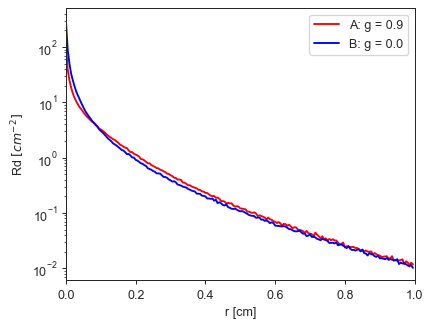

In [193]:

plt.figure(figsize=(5,4),dpi=90)
plt.plot(alphaA,RdrA,'-',c = 'red',label = 'A: g = 0.9')
plt.plot(alphaB,RdrB,'-',c = 'blue',label = "B: g = 0.0")
plt.yscale('log')
plt.xlim(0,1)
plt.legend()
plt.xlabel('r [cm]')
plt.ylabel('Rd $[cm^{-2}]$')
plt.show()

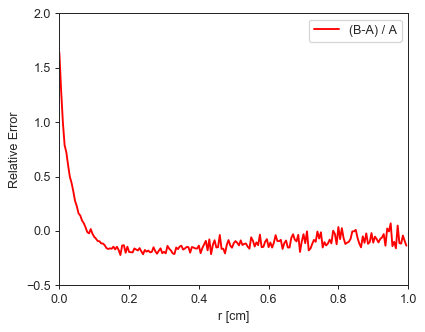

In [194]:
plt.figure(figsize=(5,4),dpi=90)
plt.plot(alphaA,(RdrB-RdrA)/RdrA,'-',c = 'red',label = '(B-A) / A')
plt.xlim(0,1)
plt.ylim(-0.5,2)
plt.legend()
plt.xlabel('r [cm]')
plt.ylabel('Relative Error')
plt.show()

In [192]:
df_ = pa.DataFrame(np.array([alphaA,RdrA,RdrB]).T,columns = ['r cm','A_Rd','B_Rd'])
df_.to_csv('result/equivalent.csv',index=None)

## Depth resolved internal fluence

In [238]:
nPh = 10000

thickness=[200]
ms = [100]
ma = [0.1]
g = [0.9]
n = [1.]
n_air = 1.

nr = 200
nz = 200
dr = 0.005
dz = 0.005

model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
fluence = IntarnalFluence(nr,nz,dr,dz)
monte = MonteCalroPh(model,fluence)
p_resultA,v_resultA,w_resultA,trace = monte.startMonteCalro(nPh)
fluenceA = fluence.Arz

thickness=[200]
ms = [100]
ma = [0.1]
g = [0.9]
n = [1.37]
n_air = 1.

model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
fluence = IntarnalFluence(nr,nz,dr,dz)
monte = MonteCalroPh(model,fluence)
p_resultB,v_resultB,w_resultB,trace = monte.startMonteCalro(nPh)
fluenceB = fluence.Arz


###### Start ######

Progress: 0.58 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 1.93 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 4.99 [％]
Calculation time: 0 minutes 1 seconds.

Progress: 12.43 [％]
Calculation time: 0 minutes 2 seconds.

Progress: 25.43 [％]
Calculation time: 0 minutes 4 seconds.

Progress: 41.6 [％]
Calculation time: 0 minutes 10 seconds.

Progress: 56.8 [％]
Calculation time: 0 minutes 20 seconds.

Progress: 68.95 [％]
Calculation time: 0 minutes 34 seconds.

Progress: 77.7 [％]
Calculation time: 0 minutes 52 seconds.

Progress: 84.52 [％]
Calculation time: 1 minutes 6 seconds.

Progress: 88.88 [％]
Calculation time: 1 minutes 15 seconds.

Progress: 92.15 [％]
Calculation time: 1 minutes 21 seconds.

Progress: 94.37 [％]
Calculation time: 1 minutes 28 seconds.


###### Result ######
Maximum step number: 16127
Photon weight reduction late: 24.756 ％
Calculation time: 1 minutes 33 seconds.

###### Start ######

Progress: 0.17 [％]
Calculation time: 0 minutes 

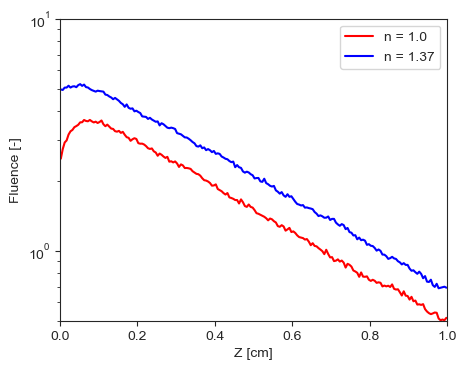

In [239]:

da = np.array([2*np.pi*(i+0.5)*dr**2 for i in range(nr)])
aaa = ma[0]*nPh*dz
phi_zA = (fluenceA.T/aaa).T.sum(0)
phi_zB = (fluenceB.T/aaa).T.sum(0)

plt.figure(figsize=(5,4),dpi=100)
plt.plot(fluence.getArrayZ(),phi_zA,c = 'red',label = 'n = 1.0')
plt.plot(fluence.getArrayZ(),phi_zB,c = 'blue',label = 'n = 1.37')
plt.xlabel('Z [cm]')
plt.ylabel('Fluence [-]')
plt.legend()
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(0.5,10)
plt.show()

In [236]:
df_ = pa.DataFrame(np.array([fluence.getArrayZ(),phi_zA,phi_zB]).T,columns = ['z cm','n_1','n_1.37'])
df_.to_csv('result/fluence_z.csv',index=None)

# Multi-layered Tissues

## Refrective and transmittnace rate

In [231]:
nPh = 1000000

thickness=[0.1,0.1,0.2]
ms = [100,10,10]
ma = [1,1,2]
g = [0.9,0.0,0.7]
n = [1.37,1.37,1.37]
n_air = 1.

model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
p_result,v_result,w_result,trace = monte.startMonteCalro(nPh)

Tt_index = np.where(v_result[2]>0)[0]
Rd_index = np.where(v_result[2]<0)[0]
print('######')
print('Mean Tt %0.6f'%(w_result[Tt_index].sum()/nPh))
print('Mean Rd %0.6f'%(w_result[Rd_index].sum()/nPh))
print()


###### Start ######

Progress: 0.206 [％]
Calculation time: 0 minutes 2 seconds.

Progress: 0.733 [％]
Calculation time: 0 minutes 5 seconds.

Progress: 3.074 [％]
Calculation time: 0 minutes 10 seconds.

Progress: 16.859 [％]
Calculation time: 0 minutes 20 seconds.

Progress: 42.325 [％]
Calculation time: 0 minutes 35 seconds.

Progress: 71.251 [％]
Calculation time: 0 minutes 52 seconds.

Progress: 92.82 [％]
Calculation time: 1 minutes 6 seconds.

Progress: 99.648 [％]
Calculation time: 1 minutes 12 seconds.

Progress: 100.0 [％]
Calculation time: 1 minutes 14 seconds.


###### Result ######
Maximum step number: 557
Photon weight reduction late: 59.681 ％
Calculation time: 1 minutes 15 seconds.
######
Mean Tt 0.200581
Mean Rd 0.202605



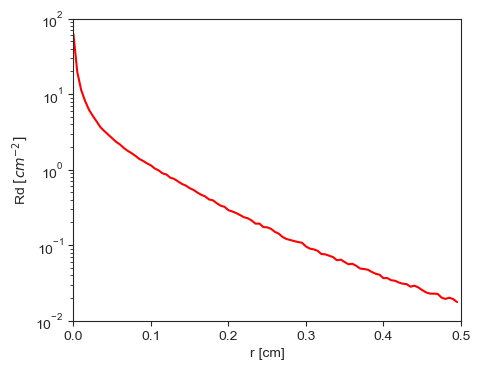

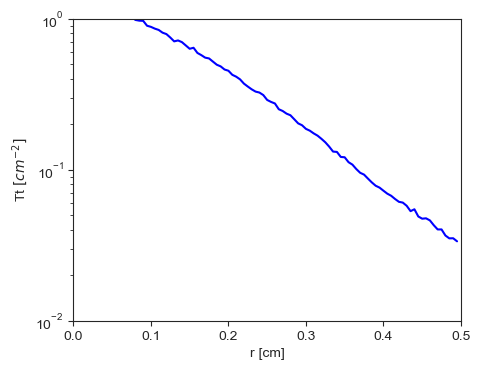

In [233]:
nn = 100
dr = 0.005

alphaRd,Rd = radialDistance(p_result[:,Rd_index],w_result[Rd_index],nn,dr)
alphaTt,Tt = radialDistance(p_result[:,Tt_index],w_result[Tt_index],nn,dr)

plt.figure(figsize=(5,4),dpi=100)
plt.plot(alphaRd,Rd,'-',c = 'red')
plt.yscale('log')
plt.xlim(0,0.5)
plt.ylim(10**-2,10**2)
plt.xlabel('r [cm]')
plt.ylabel('Rd $[cm^{-2}]$')
plt.show()

plt.figure(figsize=(5,4),dpi=100)
plt.plot(alphaTt,Tt,'-',c = 'blue')
plt.yscale('log')
plt.xlim(0,0.5)
plt.ylim(10**-2,1)
plt.xlabel('r [cm]')
plt.ylabel('Tt $[cm^{-2}]$')
plt.show()

In [ ]:
df_ = pa.DataFrame(np.array([alphaRd,Rd,Tt]).T,columns = ['r cm','Rd','Tt'])
df_.to_csv('result/multi_rt_test.csv',index=None)

## Fluence

In [28]:
nPh = 1000000

thickness=[0.1,0.1,0.2]
ms = [100,10,10]
ma = [1,1,2]
g = [0.9,0.0,0.7]
n = [1.37,1.37,1.37]
n_air = 1.

nr = 80
nz = 80
dr = 0.005
dz = 0.005

model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
fluence = IntarnalFluence(nr,nz,dr,dz)
monte = MonteCalroPh(model,fluence)
p_result,v_result,w_result,trace = monte.startMonteCalro(nPh)
fluenceRZ = fluence.Arz

Tt_index = np.where(v_result[2]>0)[0]
Rd_index = np.where(v_result[2]<0)[0]
print('######')
print('Mean Tt %0.6f'%(w_result[Tt_index].sum()/nPh))
print('Mean Rd %0.6f'%(w_result[Rd_index].sum()/nPh))
print()


###### Start ######

Progress: 0.21 [％]
Calculation time: 0 minutes 16 seconds.

Progress: 0.711 [％]
Calculation time: 0 minutes 35 seconds.

Progress: 2.538 [％]
Calculation time: 1 minutes 20 seconds.

Progress: 15.056 [％]
Calculation time: 3 minutes 6 seconds.

Progress: 44.102 [％]
Calculation time: 5 minutes 38 seconds.

Progress: 73.848 [％]
Calculation time: 7 minutes 57 seconds.

Progress: 94.167 [％]
Calculation time: 9 minutes 3 seconds.

Progress: 99.737 [％]
Calculation time: 9 minutes 16 seconds.


###### Result ######
Maximum step number: 508
Photon weight reduction late: 57.325 ％
Calculation time: 9 minutes 19 seconds.
######
Mean Tt 0.142336
Mean Rd 0.284416



Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.

Progress: 0.0 [％]
Calculation time: 0 minutes 0 seconds.


###### Result ######
Maximum step number: 88
Photon weight reduction late: 90.0 ％
Calculation time: 0 minutes 0 seconds.


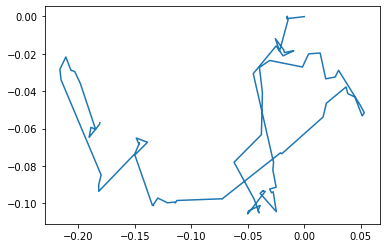

In [389]:
thickness=[200]
ms = [90]
ma = [10]
g = [0.]
n = [1.5]
n_air = 1.
model = SolidPlateModel(thickness,ma,ms,g,n,n_air)
monte = MonteCalroPh(model)
nPh = 1
v_result,p_result,w_result,trace = monte.startMonteCalro(nPh)
trace = np.array(trace[:-1])
plt.plot(traice[:,0],traice[:,2]*-1,'-')
plt.show()

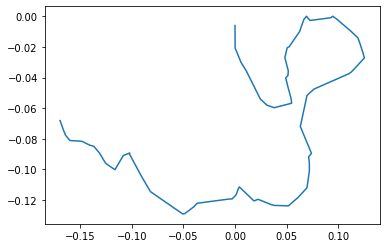

In [386]:
traice = np.array(save_p[:-1])
plt.plot(traice[:,0],traice[:,2]*-1,'-')
plt.show()

In [ ]:


def saveFile(v,p,add,w,fname = "test.csv"):
    ## 結果保存用の関数です。
    ## 計算結果は、csv形式で保存されます。
    ## x,y,ux,uy,uz,wの順で保存されます。
    
    start_ = time.time()
    hnit = ((add[0:2]-ConstPixelDims[0]/2)*ConstPixelSpacing[0]+ConstPixelSpacing[0]/2+p[0:2]).astype("float32")
    list_sample = np.array([hnit[0],hnit[1],v[0],v[1],v[2],w]).T
    f = open(fname,'w')
    try:
        for i in range(len(list_sample)):
            for j in range (len(list_sample[i])-1):
                sub_list = round(list_sample[i][j],6)
                f.write(str(sub_list))
                f.write(',')
            sub_list = round(list_sample[i][len(list_sample[i])-1],6)
            f.write(str(sub_list))
            f.write('\n')
            if list_sample[i][4] == 0:
                break
        time.sleep(1.0)
    finally:
        f.close
    fig = plt.figure(figsize=(10,6),dpi=200)
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    y = hnit[1]
    x = hnit[0]
    H = ax.hist2d(x,y, bins=2**10,cmap="plasma",norm=matplotlib.colors.LogNorm())
    ax.set_title('hist map')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    fig.colorbar(H[3],ax=ax)
    plt.show()
    calTime(time.time(), start_)
    print("File name: %s"%fname)
    

def gaussianBeam(nPh,w=0.54):
    #TEM00のビームを生成します
    r = np.linspace(-w*2,w*2,100)
    #Ir = 2*np.exp(-2*r**2/(w**2))/(np.pi*(w**2))
    Ir = np.exp(-2*r**2/(w**2))
    normd = stats.norm(0, w/2)
    x = normd.rvs(nPh)
    y = normd.rvs(nPh)
    z = np.zeros(nPh)

    fig, ax1 = plt.subplots()
    ax1.set_title('Input laser light distribution')
    ax1.hist(x, bins=100, color="C0")
    ax1.set_ylabel('Number of photon')
    ax2 = ax1.twinx()
    ax2.plot(r, Ir, color="k")
    ax2.set_xlabel('X [mm]')
    ax2.set_ylabel('Probability density')
    plt.show()

    fig = plt.figure(figsize=(10,6),dpi=70)
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    H = ax.hist2d(x,y, bins=100,cmap="plasma")
    ax.set_title('Histogram for laser light intensity')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    fig.colorbar(H[3],ax=ax)
    plt.show()
    return x,y

